# Forecasting drug sales

This report looks at forecasting the total sales (quantity) for a pharma store. The dataset was found in Kaggle (https://www.kaggle.com/milanzdravkovic/pharma-sales-data). We will primarily be focussing on the time series forecasting method of Seasonal Autoregression Integrated Moving Average (SARIMA).

In [128]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
os.chdir('/Users/akashjalil/Documents/Kaggle files/Pharma sales')

data = pd.read_csv('weekly_pharma_sales.csv')
data['datum'] = pd.to_datetime(data['datum'])
data = data.rename(columns = {'datum': 'date'})
data.head()

,date,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


We first import our dataset and change the datum column to a python datetime type and rename it as date. Our data is weekly and ranges from 5th Jan 2014 to 13th Oct 20190. The different code names are for the different types of drugs sold in the store.

* M01AB: Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
* M01AE: Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
* N02BA: Other analgesics and antipyretics, Salicylic acid and derivatives
* N02BE/B: Other analgesics and antipyretics, Pyrazolones and Anilides
* N05B: Psycholeptics drugs, Anxiolytic drugs
* N05C: Psycholeptics drugs, Hypnotics and sedatives drugs
* R03: Drugs for obstructive airway diseases
* R06: Antihistamines for systemic use

In [17]:
data['total_sales'] = data.sum(numeric_only = True, axis = 1)

We simply sum each row to get a total_sales column which we will primarily focus on forecasting. We then create a dataframe with only the date (index column) and total_sales. Let's visualise the total sales in drug for this pharmacy.

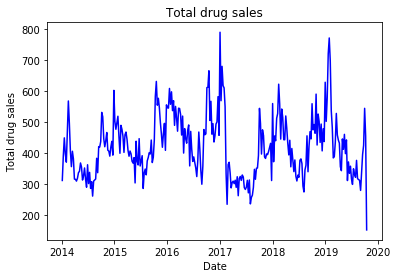

In [18]:
# Visualise the data
def PlotTimeSeries(x, y, xlabel, ylabel, title):
    plt.plot(x, y, color = 'blue')
    plt.gca().set(title = title, xlabel = xlabel, ylabel = ylabel)
    plt.show()
    
PlotTimeSeries(data.date, data.total_sales, 'Date', 'Total drug sales', 'Total drug sales')

There seems to be no general trend for drug sales from 2014 to 2019 but we can clearly see some seasonality in the data. The peak and troughs are likely caused by monthly sales so we may be able to model this through seasonality as the total sales seem to be always be lie between 500 - 1600.

Note the last point in the data is for week 41 in 2019 (2019-10-13) which shows sales of 153.5, this is significantly lower than the previous october sales we've seen in the data. This leads us to believe that week 41 in 2019 is incomplete data and we should ignore this before moving forward.

In [19]:
data['year'] = data.date.apply(lambda x: x.isocalendar()[0])
data['month_num'] = data.date.dt.month
data['month'] = data.date.dt.strftime('%b')
data['week'] = data.date.apply(lambda x: x.isocalendar()[1])
data.head()

,date,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,total_sales,year,month_num,month,week
0,2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0,312.92,2014,1,Jan,1
1,2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2,391.81,2014,1,Jan,2
2,2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0,450.31,2014,1,Jan,3
3,2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0,398.47,2014,1,Jan,4
4,2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0,371.95,2014,2,Feb,5


We will do some diagnostics on week 41 in 2019 to satisfy ourselves this data point is actually an anomoly

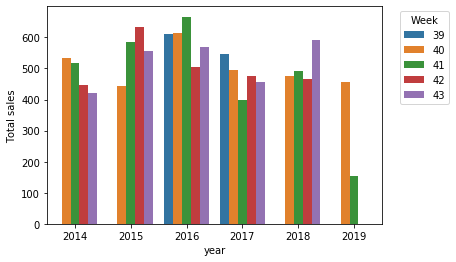

In [20]:
def OctoberSalesSummary():
    october_sales = data[data.month == 'Oct']
    october_summary = october_sales.groupby(by = ['year','week'])['total_sales'].mean(numeric_only = True).reset_index()
    
    ax = sns.barplot(x = 'year', y = 'total_sales', data = october_summary, hue = 'week')
    ax.set_ylabel('Total sales')
    plt.legend(bbox_to_anchor=(1.04,1), loc = 'upper left', title = 'Week')
    plt.show()
    
OctoberSalesSummary()

Notice how week 41 in 2019 is considerably lower than week 41 in other years. We'll remove week 2019-10-13 before moving on to visualisation.

In [21]:
data = data[data.date != dt.datetime(2019,10,13)]

In [22]:
data['year'] = data.date.apply(lambda x: x.isocalendar()[0])
data['month_num'] = data.date.dt.month
data['month'] = data.date.dt.strftime('%b')
data['week'] = data.date.apply(lambda x: x.isocalendar()[1])
data.head()

,date,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,total_sales,year,month_num,month,week
0,2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0,312.92,2014,1,Jan,1
1,2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2,391.81,2014,1,Jan,2
2,2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0,450.31,2014,1,Jan,3
3,2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0,398.47,2014,1,Jan,4
4,2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0,371.95,2014,2,Feb,5


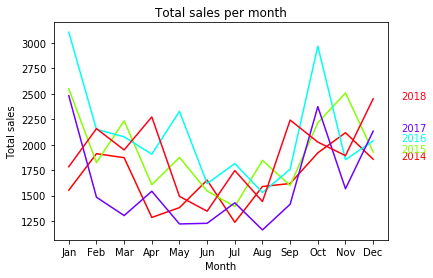

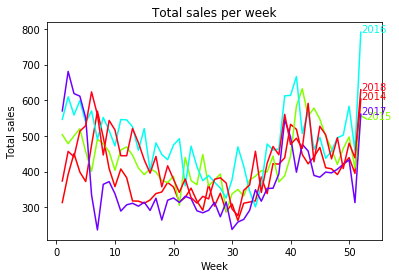

In [23]:
def PlotMonthlySeries(data, timeframe):
    years = pd.unique(data.year).tolist()
    years.pop()
    # Get a list of colours to distinguish each year
    colors_for_years = plt.cm.get_cmap('hsv', len(years))
    
    for i,year in enumerate(years):
        # Only use data from given year
        subset = data[data['year'] == year]
        if timeframe == 'month':
            # If month then sum up total_sales for the whole month to plot a smoother graph
            groupby_cols, sort_col = ['month','month_num'], 'month_num'
            subset = subset.groupby(by = groupby_cols)['total_sales'].sum().reset_index().sort_values(sort_col)
        else:
            groupby_cols, sort_col = 'week', 'week'
            subset = subset.groupby(by = groupby_cols)['total_sales'].sum().reset_index()
            
        color = colors_for_years(i)
        # Plot month and value for given year
        plt.plot(timeframe, 'total_sales', data = subset, color = color)
        # Add year as text at the last data point (Dec)
        plt.text(x = subset.shape[0], y = subset['total_sales'].values[-1], s = year, color = color)
    
    plt.gca().set(xlabel = timeframe.capitalize(), ylabel = 'Total sales', title = f'Total sales per {timeframe}')
    plt.show()
    
PlotMonthlySeries(data,'month')
PlotMonthlySeries(data,'week')

Taking the monthly sales graph first we see January as having strong volume of sales and then there is a decrease till May followed by a plateau of sles until August. From August to December there is a surge in sales with the patterning repeating in the new year. We note however 2014 and 2018 January sales were not as high as February.

On a weekly view, which will be the focus, we see a strong week 1 and 2 but then a decrease to around week 15. This is followed by either a plateau or a further decrease in sales up until week 30. From there on we see a increase in the volume of sales until week 40 with another decrease until the final week of December. We note this pattern occurs for all the years indicating a clear weekly seasonality for volume of pharma sales. 

Another way to visualise a trend or seasonality is to plot a boxplot. This will also show us the distribution of our data per month and week

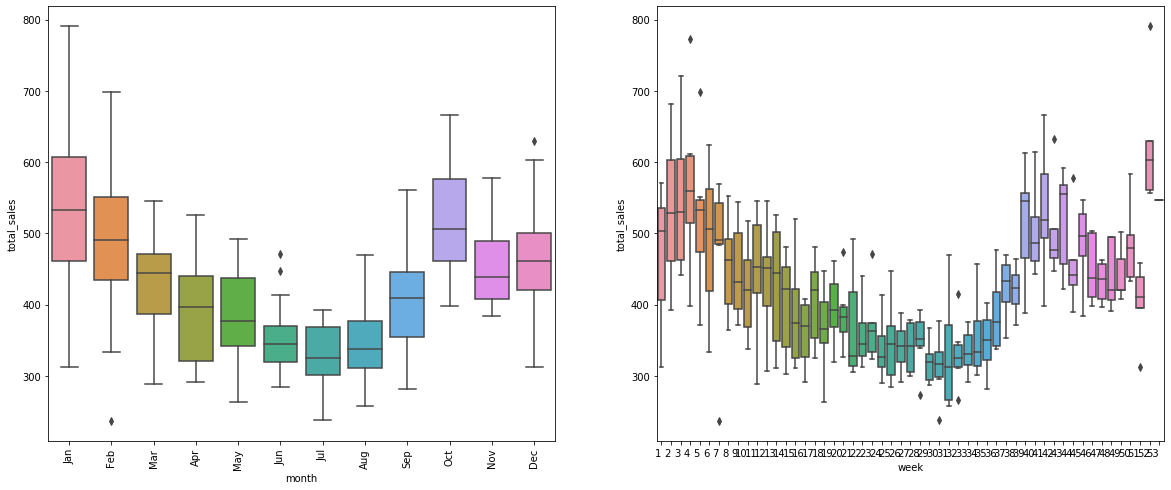

In [24]:
def BoxPlot():
    
    fig, axes = plt.subplots(1, 2, figsize = (20,8))    
    sns.boxplot(x = 'month', y = 'total_sales', data = data, ax = axes[0])
    sns.boxplot(x = 'week', y = 'total_sales', data = data, ax = axes[1]) 
    
    axes[0].settitle = 'Month-wise Boxplot'
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 90)
    
    axes[1].settitle = 'Week-wise Boxplot'
    axes[1].set_xticklabels(axes[1].get_xticklabels(), ha = 'right')
    plt.show()
    
BoxPlot()

The monthly and weekly boxplots show clear seasonality with highs in the week of December and January. Our data then has seasonality but little to no trend throughout the years.

Another way to visualise the trend and seasonality of drug sales is to decompose the sales into trend, seasonality, and the residuals (what remains after the trend and seasonality is removed from the data).

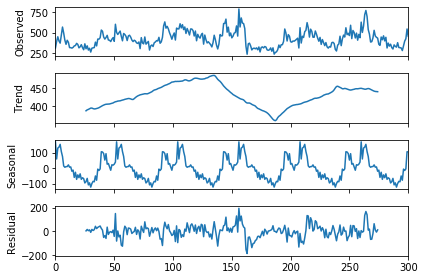

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data.total_sales, model = 'additve', freq = 52)
decomposition.plot()
plt.show()

* The trend aspect is taken as a moving average of the observed data using freq (we've used 52 as our data is represented weekly and there seems to be a six month occilation period)
* The seasonality is calculated by taken the average for each week in the data and replicating it for each year. This is why its repeating
* Residuals are simply calculated as Residuals = Observed - Trend - Seasonality

**Stationarity**

Stationarity is an important part of time series forecasting and the simple meaning of a data being stationary is the mean, variance, and covariance of a series should not be a function of time. If a time series is not stationary then it would mean the past observations would not be independent of each other.

**Why is this important?**

Time series forecasting is arguably just a linear regression applied to past observations of the data. One of the assumption of linear regression is all observations are indepedent of each other and there is little to no correlation between them.


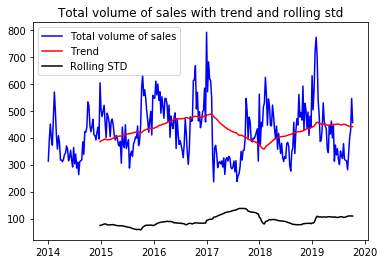

Test Statistic           -4.525919
P-value                   0.000176
Lags                      1.000000
Observations            299.000000
Critical Value (1%)      -3.452411
Critical Value (5%)      -2.871255
Critical Value (10%)     -2.571947
dtype: float64


In [48]:
from statsmodels.tsa.stattools import adfuller

def TestForStationarity(data):
    
    # Visualisation of total sales, trend, and standard deviation
    data['rolling_mean'] = data['total_sales'].rolling(window = 52).mean()
    data['rolling_std'] = data['total_sales'].rolling(window = 52).std()
    
    plt.plot(data.date, data.total_sales, color = 'Blue', label = 'Total volume of sales')
    plt.plot(data.date,data.rolling_mean, color = 'Red', label = 'Trend')
    plt.plot(data.date,data.rolling_std, color = 'Black', label = 'Rolling STD')
    
    plt.legend(loc = 'best')
    plt.title('Total volume of sales with trend and rolling std')
    plt.show()
    
    # Apply DF test where null hypothesis is that the time series is non stationary
    dftest = adfuller(data['total_sales'])
    
    df_df = pd.Series(dftest[:4], index = ['Test Statistic','P-value','Lags','Observations'])
    for k, v in dftest[4].items():
        df_df[f'Critical Value ({k})'] = v
    
    print(df_df)
    
TestForStationarity(data)

The p-value indicates the probability of the null hypothesis, which in this case is that our time series is not stationary, is true. The p-value is much smaller than the typical **alpha** of 5%, thus we can reject the null hypthesis and state our time series is a stationary processes and does not require transformation before modelling.

**Alpha** is the probability of rejecting the null hypothesis when it is in fact true. Typically, this is set at 5%. When a p-value is less than this we can safely reject the null hypothesis. However, we still have seasonality in our data and this should be removed before modelling.

The next thing to check is the autocorrelation (ACF) plot. The ACF chart will show us whether the time series is positively correlated, negatively correlated, or independent with its lags. A time series can only be modelled when we have little to no autocorrelation. We refer back to the statistical assumptions of linear regression.

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

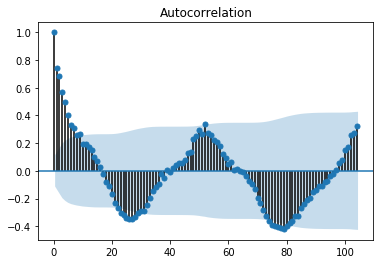

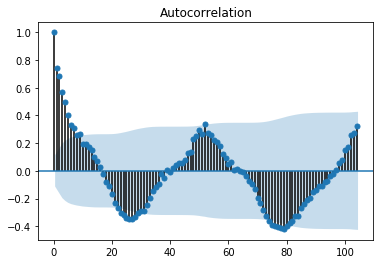

In [52]:
plot_acf(data.total_sales, lags = 104)

The only thing left to deal with is seasonality. See how the data is correlated every 24-26 weeks. One way to remove this is by simply subtracting the series from itself with a lag of 1. This is a simple differencing method.

In [45]:
data['diff1'] = data['total_sales'] - data['total_sales'].shift(1)

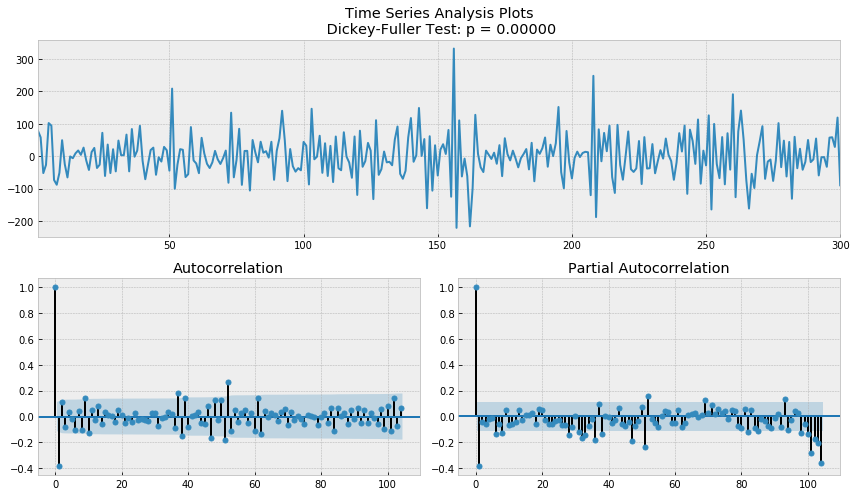

In [100]:
def PlotSeriesAndACF(series):
    lags = 104
    with plt.style.context('bmh'):    
        fig = plt.figure(figsize = (12,7))
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y = series.dropna()
        y.plot(ax = ts_ax)
        
        p_value = adfuller(y)[1]
        
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller Test: p = {0:.5f}'.format(p_value))
        plot_acf(y, lags = lags, ax = acf_ax)
        plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()

PlotSeriesAndACF(data['diff1'])

Now our series is stationary according to the Dickey Fuller test and we've removed the seasonality by taking a single difference. We can finally move on to modelling.

The model we'll be using is the Seasonal Autoregression Integrated Moving Average (SARIMA)(*p,d,q)(P,D,Q,s)*. This is a model which adds a seasonal approach to the famous ARIMA model. The elements of the model are:

* **AR(p)** - Regression of the series on to itself. The hyperparameter p can be estimated using the PACF for the last significant lag that is significant (outside blue region) before others become insignificant. In our case this would be 1.

* **I(d)** - The integrated element is the number of non-seasonal differences. This is also 1 as we only took a first difference to remove seasonality.

* **MA(q)** - Regression of errors. The hyperparameter q can be estimated similarly to **AR(p)** but using the ACF. Again this looks like to be 1.

* **P** - This is the autoregressive part of the seasonal component of the model. To estimate this we need to decide our many of our periods lengths are significant in the PACF chart. Our data is weekly so the period length is 52 weeks. We notice period 52 and 104 are significant so we can choose P = 2.

* **D** - Number of seasonal differencing use. We did not need to do this for our data so D = 0

* **Q** - Similar to **P** but for the moving average component so we use the ACF plot to decide this. For this it seems only period 52 is significant and period 104 is insignificant. So Q = 1

* **S(s)** - This is the seasonilty aspect and is the period length of the series. As our data is weekly this is simply 52

Rather than using exact values for the hyperparameters we'll build various models with different models as our choice may not be optimal.

In [66]:
p = range(0,3)
d = 1
q = range(0,3)

P = range(0,3)
D = 0
Q = 1
S = 52

In [67]:
from itertools import product

# Create a list of all combinations of hyperparameters to be used
all_parameters = list(product(p, q, P))

print('Number of models we will build: %s' %len(all_parameters))

Number of models we will build: 27


In [77]:
from statsmodels.tsa.statespace import sarimax
import numpy as np
from sklearn import metrics

def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        
        return np.mean(np.abs(1 - y_pred/y_true))

def BuildSarimaModels(all_parameters, Q = 1, d = 1, D = 0, S = 52):
    
    results_to_store = []
    actual = data.total_sales[S+d:].values
        
    for parameters in all_parameters:
        
        p, q, P = parameters
        
        # Some parameter combinations will fail to converge and these need to be ignored
        try:
            model = sarimax.SARIMAX(data.total_sales, order = (p,d,q), seasonal_order = (P,D,Q,S))
            results = model.fit(disp = 0)
        
        except:
            continue
        
        if results.mle_retvals['converged']:
            
            aic = results.aic

            predicted = results.fittedvalues[S+d:].values

            mae = metrics.mean_absolute_error(actual, predicted)
            mse = metrics.mean_squared_error(actual, predicted)    
            mape = mean_absolute_percentage_error(actual, predicted)  

            results_to_store.append([parameters, aic, mae, mse, mape])

    results_table = pd.DataFrame(results_to_store, columns = ['Parameters','AIC','MAE','MSE','MAPE'])
    
    return results_table

sarimax_models = BuildSarimaModels(all_parameters)
sarimax_models = sarimax_models.sort_values(by = 'AIC', ascending = True)

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

In [78]:
sarimax_models

,Parameters,AIC,MAE,MSE,MAPE
21,"(2, 1, 0)",3325.602096,46.290328,3811.603145,0.108594
23,"(2, 2, 1)",3325.804204,45.832352,3748.364386,0.108245
22,"(2, 2, 0)",3327.425068,46.399545,3806.036574,0.108893
4,"(0, 1, 1)",3336.240546,46.737515,4004.659684,0.109985
13,"(1, 1, 1)",3337.591374,46.092831,3979.980121,0.108577
7,"(0, 2, 1)",3338.214267,46.693334,4004.038965,0.109858
5,"(0, 1, 2)",3338.218964,46.691247,4004.369046,0.109841
10,"(1, 0, 1)",3339.241816,47.649323,4039.518067,0.112320
3,"(0, 1, 0)",3339.496356,47.197960,4097.700111,0.109955
9,"(1, 0, 0)",3339.517634,47.367159,4077.409140,0.110984


Using the smallest AIC we see that a SARIMA(2,1,1)(0,0,1,52) model fits our time series the best. It also has one of the lowest MAE (mean absolute error), MSE (mean square error), and MAPE (mean absolute percentage error) scores.

In [109]:
data = data[['date','total_sales']]
data = data.set_index('date')
def BestModel(p = 2, d = 1, q = 1, P = 0, D = 0, Q = 1, S = 52):
    model = sarimax.SARIMAX(data.total_sales, order = (p,d,q), seasonal_order = (P,D,Q,S))
    results = model.fit()
    
    return results

best_model = BestModel()

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [110]:
best_model.mle_retvals['converged']

True

In [111]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        total_sales   No. Observations:                  301
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 52)   Log Likelihood               -1657.801
Date:                            Thu, 24 Sep 2020   AIC                           3325.602
Time:                                    15:24:37   BIC                           3344.121
Sample:                                01-05-2014   HQIC                          3333.013
                                     - 10-06-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5436      0.048     11.222      0.000       0.449       0.639
ar.L2          0.2752      0.050      5.460      0.000       0.176       0.374
ma.L1         -0.9999      1.164     -0.859      0.390      -3.282       1.282
ma.S.L52       0.2704      0.047      5.776      0.000       0.179       0.362
sigma2      3608.7773   4153.713      0.869      0.385   -4532.350    1.17e+04
===================================================================================
Ljung-Box (Q):                       33.63   Jarque-Bera (JB):                84.81
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.51
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary statistics show us the coefficients for our model terms and also the p values of the terms. We would prefer all terms to have significant terms but we notice the moving average term being high insignificant due to large a p value. However because this particular model had the lowest AIC, MAE, and one of lowest MSE and MAPE we will keep the insignificant term as a trade off.

The next thing to check is are the residuals. We would like to see constant mean and variance within the residuals and one way to check this to make there are no patterns in the residual plot and no autocorrelation.

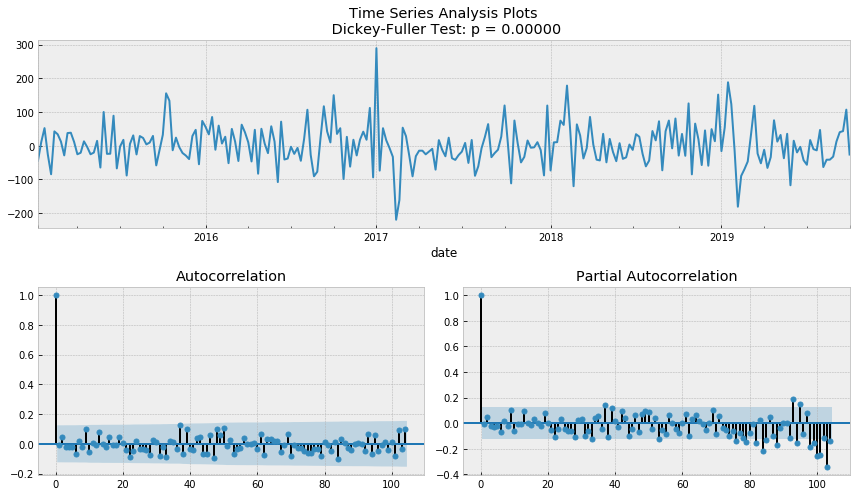

In [112]:
PlotSeriesAndACF(best_model.resid[S+d:])

The residuals (difference between actual and predicted) are stationary, have no trend or repeating patter, and have no autocorrelations

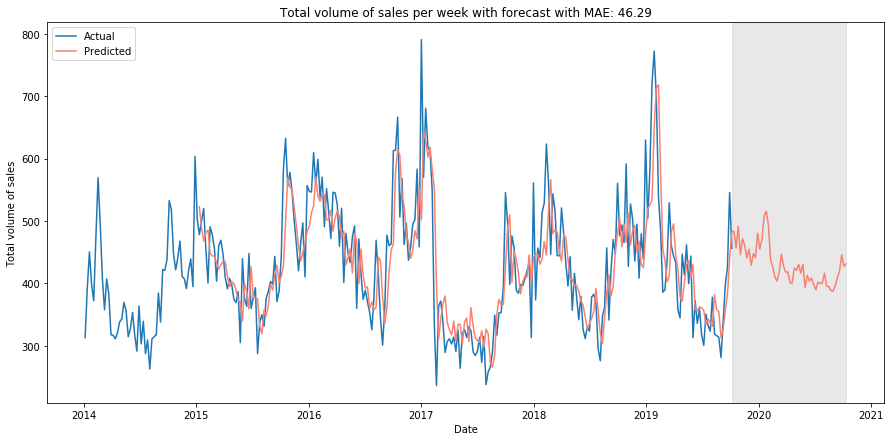

In [123]:
def PlotPredictedAndActuals(data, model, future_steps):

    prediction_index = data.shape[0]
    
    data['predicted'] = model.fittedvalues
    # Make first 52 predictions null
    data['predicted'][:53] = np.NaN
    
    mae = round(metrics.mean_absolute_error(data.total_sales[53:], data.predicted[53:]),2)
    
    forecast = model.predict(start = prediction_index, end = prediction_index + future_steps)
    
    forecast = data.predicted.append(forecast)
    
    plt.figure(figsize=(15, 7))
    plt.plot(data.total_sales, label = 'Actual')
    plt.plot(forecast, color = 'salmon', label = 'Predicted', ls = '-')
    plt.axvspan(data.index[-1], forecast.index[-1], alpha = 0.5, color='lightgrey')
    plt.legend(loc = 'best')
    plt.xlabel('Date')
    plt.ylabel('Total volume of sales')
    plt.title('Total volume of sales per week with forecast with MAE: %s' %mae)
    plt.show()
    
    return data.merge(forecast.to_frame('forecast'), how = 'outer', left_index = True, right_index = True).drop('predicted', axis = 1)

data_with_forecast = PlotPredictedAndActuals(data, best_model, 52)

We seem to have adequate predictions from the SARIMA model. We have definitely captured the seasonility aspect of our original time series. This model on average is off by 11%. The SARIMA is then quite a good fit for this data. Note we did not try to fit an ARIMA model simply due to the data having such a high seasonality aspect which the ARIMA can not model.